In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

# Simply celebrity image classification using a convolutional neural network


### This project is a modification of an image classifier project provided in the following links
 * https://github.com/pytorch/tutorials/blob/main/beginner_source/blitz/cifar10_tutorial.py
 * https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/4e865243430a47a00d551ca0579a6f6c/cifar10_tutorial.ipynb
 
and is modified in order to classsify images provided in the "Dataset" folder instead of using the CIFAR10 image dataset (which is provided as an object) from the torchvision package.



# Training a Classifier

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, a package called
``torchvision`` was created in the reference project, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

For this tutorial, we will use a face recognition dataset provided in https://www.kaggle.com/datasets/cybersimar08/face-recognition-dataset.
These images where resized in powershell with a function provided in https://gist.github.com/someshinyobject/617bf00556bc43af87cd.
It has the classes of celebrities like: 'Billie Eilish', or 'Brad Pitt'. The images are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the face recognition training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize image data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
import pandas as pd
import pyarrow
from more_itertools import flatten
import numpy as np

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size =  6

# load image set
orig_set=torchvision.datasets.ImageFolder(root=r".\Dataset\Facesmodified",transform=transform)

# functions for greping a subset in a list
grep_first_chunk_in_list=lambda x : x[0:int(len(x)*0.1)]
grep_remaining_chunk_in_list=lambda x : x[int(len(x)*0.1):]

# build list that relates the index of "orig_set" to the image folder by listing the person id
X=pd.DataFrame([orig_set.imgs[i][1] for i in range(len(orig_set))])

# build train and test set indices by making a train-test split for all image indices belonging to each person id
test_indices=list(flatten([grep_first_chunk_in_list(np.where(X==i)[0]) for i in pd.unique(pd.Series(X.iloc[:,0]))]))
train_indices=list(flatten([grep_remaining_chunk_in_list(np.where(X==i)[0]) for i in pd.unique(pd.Series(X.iloc[:,0]))]))

# finally build train and test set
testset = torch.utils.data.Subset(orig_set, test_indices)  # take first 10% for each person
trainset = torch.utils.data.Subset(orig_set, train_indices)  # take the rest 


In [5]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
classes=orig_set.classes


Let us show some of the training images, for fun.



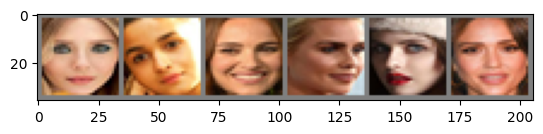

[Elizabeth Olsen]  [Alia Bhatt]  [Natalie Portman]  [Claire Holt]  [Alexandra Daddario]  [Jessica Alba] 


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'[{classes[labels[j]]:5s}] ' for j in range(len(labels))))

### 2. Define a Convolutional Neural Network


In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 31)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:
for epoch in range(150):  # loop over the dataset multiple times
    # dataiter = iter(trainloader)
    # images, labels = next(dataiter)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


Let's quickly save our trained model:



In [10]:
PATH = './model.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 150 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



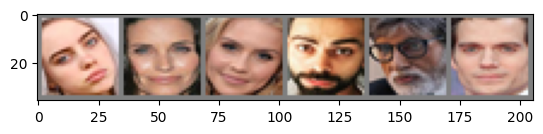

GroundTruth:  [Billie Eilish]  [Courtney Cox]  [Claire Holt]  [Virat Kohli]  [Amitabh Bachchan]  [Henry Cavill] 


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'[{classes[labels[j]]:5s}] ' for j in range(len(labels))))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [13]:
outputs = net(images)

The outputs are energies for the 31 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'[{classes[predicted[j]]:5s}] '
                              for j in range(len(labels))))

Predicted:  [Margot Robbie]  [Jessica Alba]  [Claire Holt]  [Virat Kohli]  [Amitabh Bachchan]  [Henry Cavill] 


The results seem okay but for many examples there is no match.

Let us look at how the network performs on the whole dataset.



In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


That looks way better than chance, which is 3% accuracy (randomly picking
a class out of 31 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / (total_pred[classname])
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Akshay Kumar is 50.0 %
Accuracy for class: Alexandra Daddario is 25.0 %
Accuracy for class: Alia Bhatt is 25.0 %
Accuracy for class: Amitabh Bachchan is 100.0 %
Accuracy for class: Andy Samberg is 75.0 %
Accuracy for class: Anushka Sharma is 50.0 %
Accuracy for class: Billie Eilish is 25.0 %
Accuracy for class: Brad Pitt is 0.0 %
Accuracy for class: Camila Cabello is 100.0 %
Accuracy for class: Charlize Theron is 50.0 %
Accuracy for class: Claire Holt is 75.0 %
Accuracy for class: Courtney Cox is 50.0 %
Accuracy for class: Dwayne Johnson is 50.0 %
Accuracy for class: Elizabeth Olsen is 25.0 %
Accuracy for class: Ellen Degeneres is 100.0 %
Accuracy for class: Henry Cavill is 50.0 %
Accuracy for class: Hrithik Roshan is 75.0 %
Accuracy for class: Hugh Jackman is 50.0 %
Accuracy for class: Jessica Alba is 0.0 %
Accuracy for class: Kashyap is 33.3 %
Accuracy for class: Lisa Kudrow is 100.0 %
Accuracy for class: Margot Robbie is 50.0 %
Accuracy for class: Marmik is 33.3 

Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [18]:
del dataiter